# Welcome to the Quantum Parallel Universe

### Before Running this Notebook

- Create a `token.txt` file in the same folder as this notebook
  - `token.txt` should contain a token sufficient for [`qiskit_ibm_provider.IBMProvider()`](https://github.com/Qiskit/qiskit-ibm-provider#enable-account-for-current-session) authentication.

---

### Imports

In [1]:
import math
from qiskit import execute, QuantumCircuit
from qiskit.circuit import Qubit
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMBackend, IBMProvider, least_busy

### Globals

#### Manually Managed Variables

In [2]:
# number of qubits
N = 8

# use simulator
use_sim = True

# shots
shots = 1024

#### Automanaged Variables

In [3]:
# IBM token
token = None

# linear complexity GHZ circuit
linear_complexity_circuit = None

# linear complexity mapped circuit
linear_complexity_mapped_circuit = None

# linear complexity job
linear_complexity_job = None

# linear complexity result
linear_complexity_result = None

# logarithmic complexity GHZ circuit
log_complexity_circuit = None

# log complexity mapped circuit
log_complexity_mapped_circuit = None

# log complexity job
log_complexity_job = None

# log complexity result
log_complexity_result = None

# IBMBackend
backend = None


### Generate Linear Time Complexity Circuits for $|\text{GHZ}_N\rangle$

In [4]:
def linear_complexity_GHZ(N: int) -> QuantumCircuit:
  if not isinstance(N, int):
    raise TypeError("Only integer arguments accepted.")
  if N < 1:
    raise ValueError("There must be one or more qubits.")

  c = QuantumCircuit(N)
  for i in range(N):
    c.reset(i)
  c.h(0)
  for i in range(1, N):
    c.cx(i-1, i)
  c.measure_active()
  return c

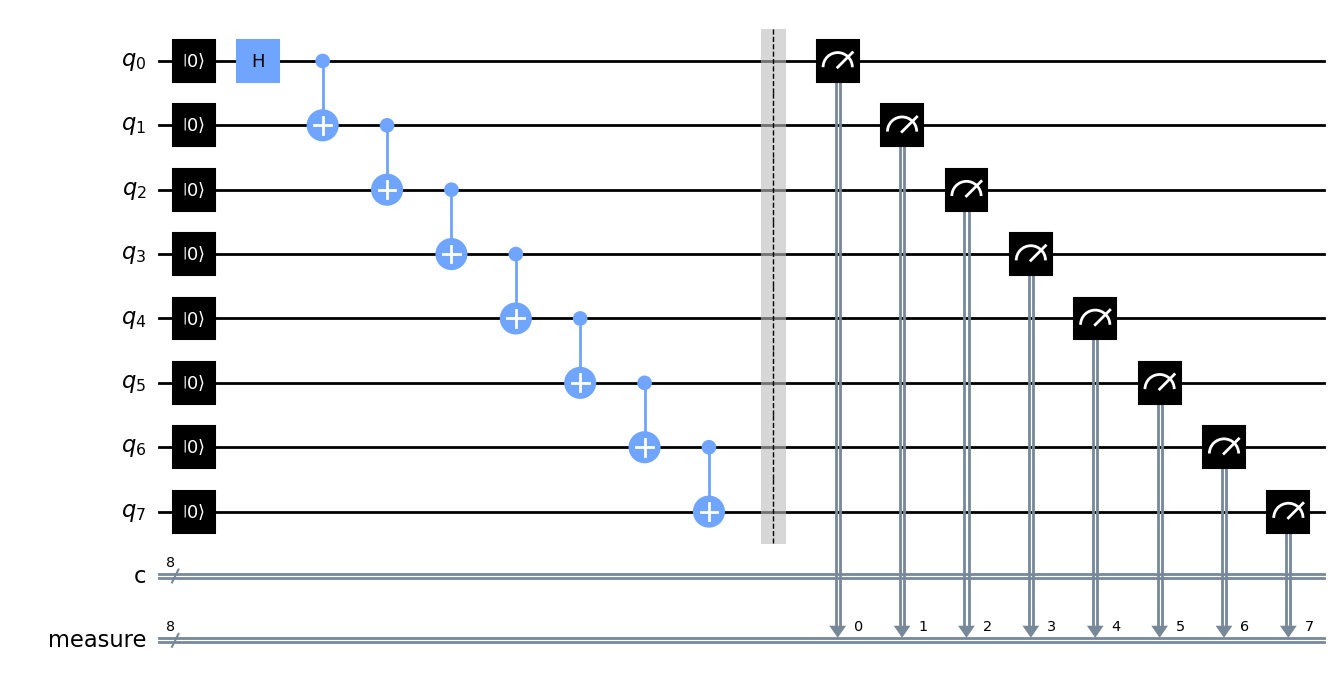

In [5]:
linear_complexity_circuit = linear_complexity_GHZ(N)
linear_complexity_circuit.draw(output='mpl')

### Generate Logaritmic Complexity Circuits for $|\text{GHZ}_{2^m}\rangle$

In [6]:
def _log_complexity_GHZ(m: int) -> QuantumCircuit:
  if not isinstance(m, int):
    raise TypeError("Only integer arguments accepted.")
  if m < 0:
    raise ValueError("`m` must be at least 0 (evaluated 2^m).")

  if m == 0:
    c = QuantumCircuit([Qubit()])
    c.reset(0)
    c.h(0)
  else:
    c = _log_complexity_GHZ(m - 1)
    for i in range(c.num_qubits):
      c.add_bits([Qubit()])
      new_qubit_index = c.num_qubits - 1
      c.reset(new_qubit_index)
      c.cx(i, new_qubit_index)
  return c

### Generate Logaritmic Complexity Circuits for $|\text{GHZ}_N\rangle$

In [7]:
def log_complexity_GHZ(N: int) -> QuantumCircuit:
  if not isinstance(N, int):
    raise TypeError("Only an integer argument is accepted.")
  if N < 1:
    raise ValueError("There must be one or more qubits.")

  m = math.ceil(math.log2(N))
  num_qubits_to_erase = 2**m - N
  old_circuit = _log_complexity_GHZ(m=m)
  new_num_qubits = old_circuit.num_qubits - num_qubits_to_erase
  new_circuit = QuantumCircuit(new_num_qubits)
  for gate in old_circuit.data:
    qubits_affected = gate.qubits
    if all(old_circuit.find_bit(qubit).index < new_num_qubits for qubit in qubits_affected):
      new_circuit.append(gate[0], [old_circuit.find_bit(qubit).index for qubit in qubits_affected])
  new_circuit.measure_active()
  return new_circuit


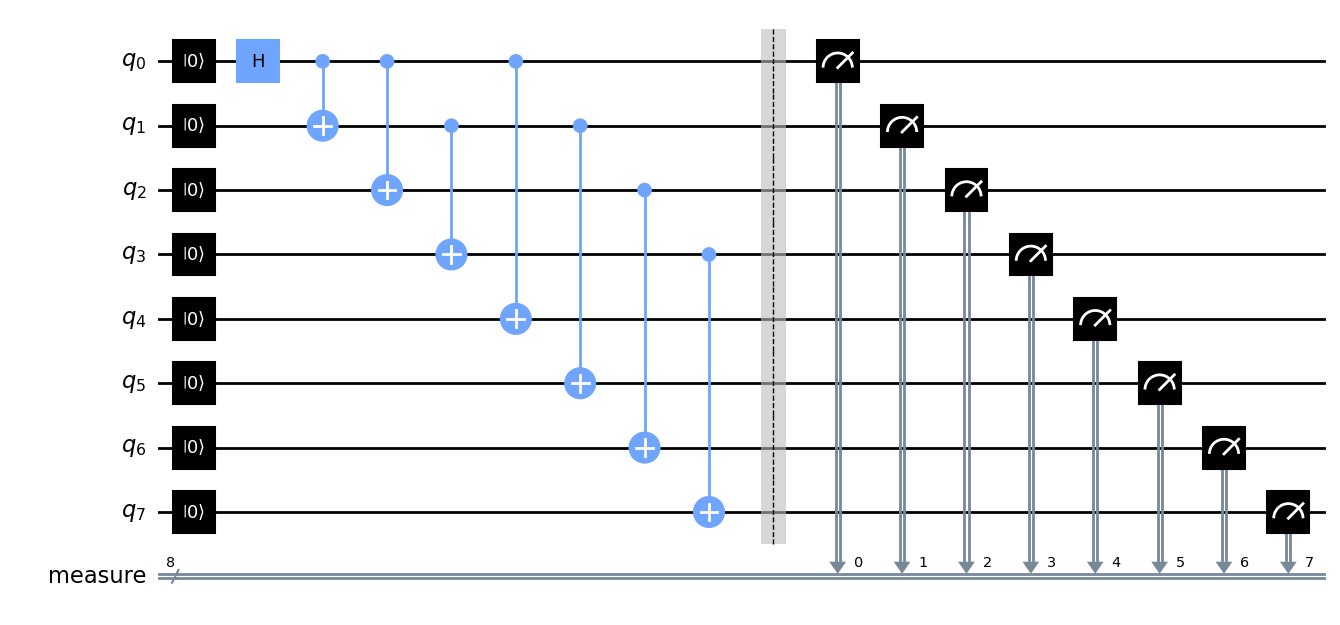

In [8]:
log_complexity_circuit = log_complexity_GHZ(N)
log_complexity_circuit.draw(output='mpl')

---

### Get Token

In [9]:
with open('token.txt', 'r') as f:
  token = f.read().strip()

### Setup IBM Machine

In [10]:
backend = least_busy(IBMProvider(token).backends(min_num_qubits=N, simulator=use_sim, operational=True))

### Transpile Circuits

```python
linear_complexity_mapped_circuit = transpile(linear_complexity_circuit, backend=backend)
log_complexity_mapped_circuit = transpile(log_complexity_circuit, backend=backend)
```

### Run Circuits

In [11]:
linear_complexity_job = execute(linear_complexity_circuit, backend=backend, shots=shots)
log_complexity_job = execute(log_complexity_circuit, backend=backend, shots=shots)

TranspilerError: "The number of qubits for Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]) does not match the number of qubits in the properties dictionary: (0,)"

### Results

In [ ]:
linear_complexity_result = linear_complexity_job.result()
log_complexity_result = log_complexity_job.result()